**Lab 6 – Explainable AI**

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/phonchi/nsysu-math608/blob/master/static_files/presentations/06_XAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/phonchi/nsysu-math608/blob/master/static_files/presentations/06_XAI.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

In [1]:
!pip install --upgrade mlxtend -qq
!pip install imodels -qq
!pip install dtreeviz -qq
!pip install lime -qq
!pip install shap -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.5/195.5 KB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.5/90.5 KB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 KB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 KB 11.7 MB/s eta 0:00:00


In [2]:
# Scientific computing
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import cm
%matplotlib inline

# Preprocessing and datasets
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import QuantileTransformer
from sklearn.datasets import fetch_california_housing
from sklearn.datasets import load_iris
from sklearn.datasets import fetch_openml

# Modeling
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree, DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
import tensorflow as tf

# Interpretable Models
from imodels import RuleFitRegressor
from imodels import OneRClassifier, BayesianRuleListClassifier, FIGSClassifier, HSTreeClassifierCV
from imodels.discretization import ExtraBasicDiscretizer
from imodels.tree.viz_utils import extract_sklearn_tree_from_figs

# Model-Agnostic Methods
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence

# Local methods
import lime
import lime.lime_tabular
from lime import lime_image
import shap  # package used to calculate Shap values

# Helper functions
from skimage.io import imread
from skimage.segmentation import mark_boundaries
from scipy.io.arff import loadarff
import graphviz
import dtreeviz

import logging
import warnings
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL) # For dtreeviz
warnings.filterwarnings("ignore", category=DeprecationWarning) # For shap

In [3]:
!gdown --fuzzy https://drive.google.com/file/d/1GzAuz0gkk5arJPYC7NgnCrkVWS4rvTtW/view?usp=sharing
!gdown --fuzzy https://drive.google.com/file/d/1GvSaZ1E45e45ns5IH8Y6EoVu8C6Vhffy/view?usp=sharing

Downloading...
From: https://drive.google.com/uc?id=1GzAuz0gkk5arJPYC7NgnCrkVWS4rvTtW
To: /content/diabetes.arff
100% 37.4k/37.4k [00:00<00:00, 54.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1GvSaZ1E45e45ns5IH8Y6EoVu8C6Vhffy
To: /content/FIFA 2018 Statistics.csv
100% 12.6k/12.6k [00:00<00:00, 25.4MB/s]


## Decsion-Rule based modeld by `imodels`

`imodels` provides a simple interface for fitting and using state-of-the-art interpretable models, all compatible with `scikit-learn`. These models can often replace black-box models (e.g. random forests) with simpler models (e.g. rule lists) while improving interpretability and computational efficiency, all without sacrificing predictive accuracy!

In [4]:
np.random.seed(13)

def get_ames_data():
    try:
        housing = fetch_openml(name="house_prices", as_frame=True, parser='auto')
    except:
        housing = fetch_openml(name="house_prices", as_frame=True)

    housing_target = housing['target'].values
    housing_data_numeric = housing['data'].select_dtypes('number').drop(columns=['Id']).dropna(axis=1)
    feature_names = housing_data_numeric.columns.values
    X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
        housing_data_numeric.values, housing_target, test_size=0.75)
    return X_train_reg, X_test_reg, y_train_reg, y_test_reg, feature_names

def get_diabetes_data():
    '''load (classification) data on diabetes
    '''
    data = loadarff("diabetes.arff")
    data_np = np.array(list(map(lambda x: np.array(list(x)), data[0])))
    X = data_np[:, :-1].astype('float32')
    y_text = data_np[:, -1].astype('str')
    y = (y_text == 'tested_positive').astype(int)  # labels 0-1
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75)  # split
    feature_names = ["#Pregnant", "Glucose concentration test", "Blood pressure(mmHg)",
                     "Triceps skin fold thickness(mm)",
                     "2-Hour serum insulin (mu U/ml)", "Body mass index", "Diabetes pedigree function", "Age (years)"]
    return X_train, X_test, y_train, y_test, feature_names

def viz_classification_preds(probs, y_test):
    '''look at prediction breakdown
    '''
    plt.subplot(121)
    plt.hist(probs[:, 1][y_test == 0], label='Class 0')
    plt.hist(probs[:, 1][y_test == 1], label='Class 1', alpha=0.8)
    plt.ylabel('Count')
    plt.xlabel('Predicted probability of class 1')
    plt.legend()

    plt.subplot(122)
    preds = np.argmax(probs, axis=1)
    plt.title('ROC curve')
    fpr, tpr, thresholds = metrics.roc_curve(y_test, preds)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.plot(fpr, tpr)
    plt.tight_layout()
    plt.show()

The Ames dataset is a housing dataset that use seveal conditions to predict the housing price. The diabetes dataset has a binary-valued variable. We would like to investigated whether the patient shows signs of diabetes according to World Health Organization criteria.

In [5]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg, feat_names_reg = get_ames_data()
X_train, X_test, y_train, y_test, feat_names = get_diabetes_data()

In [6]:
pd.DataFrame(X_train_reg, columns=feat_names_reg)

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,50,6435,6,5,1939,1950,0,0,972,972,...,312,0,0,0,0,0,0,0,10,2006
1,20,10200,5,7,1954,2003,320,362,404,1086,...,490,0,0,0,0,0,0,0,5,2010
2,20,9503,5,5,1958,1983,457,374,193,1024,...,484,316,28,0,0,0,0,0,6,2007
3,60,9000,8,5,2008,2008,0,0,768,768,...,676,0,30,0,0,0,0,0,6,2009
4,80,19690,6,7,1966,1966,0,0,697,697,...,432,586,236,0,0,0,738,0,8,2006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,20,10656,8,5,2006,2007,0,0,1638,1638,...,870,192,80,0,0,0,0,0,11,2007
361,20,8450,7,5,2000,2001,0,0,1349,1349,...,539,120,55,0,0,0,0,0,12,2007
362,50,5790,3,6,1915,1950,0,0,840,840,...,379,0,0,202,0,0,0,0,5,2010
363,60,10029,6,5,1988,1989,831,0,320,1151,...,521,0,228,0,0,192,0,0,9,2007


In [12]:
y_train_reg[:10]

array([140200, 144900, 144000, 210000, 274970, 218000, 167500, 195400,
        76000, 246578])

In [9]:
pd.DataFrame(X_train, columns=feat_names)

,#Pregnant,Glucose concentration test,Blood pressure(mmHg),Triceps skin fold thickness(mm),2-Hour serum insulin (mu U/ml),Body mass index,Diabetes pedigree function,Age (years)
0,3.0,158.0,76.0,36.0,245.0,31.600000,0.851,28.0
1,8.0,186.0,90.0,35.0,225.0,34.500000,0.423,37.0
2,2.0,85.0,65.0,0.0,0.0,39.599998,0.930,27.0
3,3.0,187.0,70.0,22.0,200.0,36.400002,0.408,36.0
4,6.0,93.0,50.0,30.0,64.0,28.700001,0.356,23.0
...,...,...,...,...,...,...,...,...
187,0.0,165.0,76.0,43.0,255.0,47.900002,0.259,26.0
188,8.0,181.0,68.0,36.0,495.0,30.100000,0.615,60.0
189,0.0,111.0,65.0,0.0,0.0,24.600000,0.660,31.0
190,3.0,129.0,92.0,49.0,155.0,36.400002,0.968,32.0


In [13]:
y_train[:10]

array([1, 1, 0, 1, 0, 0, 0, 0, 1, 0])

We will now show how to fit different models. All models support the `fit()` and `predict()` method (classifiers also support `predict_proba()`).

The simplest way to visualize a fitted model `m` is usually just to call `str(m)` or `print(m)`. Some models have custom methods that allow you to visualize them further. To pass feature names into a model for visualization, you can usually (i) pass in the `feature_names` argument to the `fit()` function or (ii) pass in a pandas dataframe with the feature names as column names.

### Rule lists

Rule list is nonoverlapping

#### oneR
Fits a rule list restricted to use only one feature

Classifier Accuracy: 0.6649305555555556 
 Learned interpretable model:
 > ------------------------------
> Greedy Rule List
> ------------------------------
↓
24.11% risk (192 pts)
	if #Pregnant ==> 60.8% risk (51 pts)
↓
19.51% risk (141 pts)
	if #Pregnant ==> 30.5% risk (59 pts)
↓
15.38% risk (82 pts)
	if ~#Pregnant ==> 26.700000000000003% risk (30 pts)
↓
12.5% risk (52 pts)
	if #Pregnant ==> 20.0% risk (20 pts)



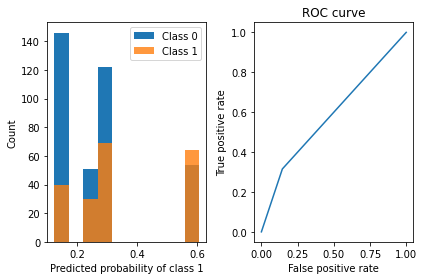

In [40]:
# fit a oneR model
model = OneRClassifier()
model.fit(X_train, y=y_train, feature_names=feat_names) # stores into m.rules_
probs = model.predict_proba(X_test)
preds = model.predict(X_test)

# print the rule list
print("Classifier Accuracy:", np.mean(y_test == preds), "\n Learned interpretable model:\n", model)

# look at prediction breakdown
viz_classification_preds(probs, y_test)

In [42]:
model.rules_

[{'col': '#Pregnant',
  'index_col': 0,
  'cutoff': 6.5,
  'val': 0.24113475177304963,
  'flip': False,
  'val_right': 0.6078431372549019,
  'num_pts': 192,
  'num_pts_right': 51},
 {'col': '#Pregnant',
  'index_col': 0,
  'cutoff': 2.5,
  'val': 0.1951219512195122,
  'flip': False,
  'val_right': 0.3050847457627119,
  'num_pts': 141,
  'num_pts_right': 59},
 {'col': '#Pregnant',
  'index_col': 0,
  'cutoff': 0.5,
  'val': 0.15384615384615385,
  'flip': True,
  'val_right': 0.26666666666666666,
  'num_pts': 82,
  'num_pts_right': 30},
 {'col': '#Pregnant',
  'index_col': 0,
  'cutoff': 1.5,
  'val': 0.125,
  'flip': False,
  'val_right': 0.2,
  'num_pts': 52,
  'num_pts_right': 20}]

#### Bayesian rule lists

In [46]:
# train classifier (allow more iterations for better accuracy; use BigDataRuleListClassifier for large datasets)
# All numeric features must be discretized prior to fitting!
disc = ExtraBasicDiscretizer(feat_names, n_bins=3, strategy='uniform')
X_train_disc = disc.fit_transform(pd.DataFrame(X_train, columns=feat_names))
X_test_disc = disc.transform(pd.DataFrame(X_test, columns=feat_names))

X_train_disc

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


,#Pregnant_0.0_to_4.666666666666667,#Pregnant_4.666666666666667_to_9.333333333333334,#Pregnant_9.333333333333334_to_14.0,Glucose concentration test_44.0_to_95.66666666666666,Glucose concentration test_95.66666666666666_to_147.33333333333331,Glucose concentration test_147.33333333333331_to_199.0,Blood pressure(mmHg)_0.0_to_40.666666666666664,Blood pressure(mmHg)_40.666666666666664_to_81.33333333333333,Blood pressure(mmHg)_81.33333333333333_to_122.0,Triceps skin fold thickness(mm)_0.0_to_21.0,...,2-Hour serum insulin (mu U/ml)_330.0_to_495.0,Body mass index_0.0_to_19.8000005086263,Body mass index_19.8000005086263_to_39.6000010172526,Body mass index_39.6000010172526_to_59.400001525878906,Diabetes pedigree function_0.10199999809265137_to_0.874666690826416,Diabetes pedigree function_0.874666690826416_to_1.6473333835601807,Diabetes pedigree function_1.6473333835601807_to_2.4200000762939453,Age (years)_21.0_to_36.333333333333336,Age (years)_36.333333333333336_to_51.66666666666667,Age (years)_51.66666666666667_to_67.0
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
188,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
189,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
190,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


RuleListClassifier Accuracy: 0.7309027777777778 
 Learned interpretable model:
 Trained RuleListClassifier for detecting diabetes
IF Body mass index_39.6000010172526_to_59.400001525878906 > 0.5 THEN probability of diabetes: 50.0% (30.6%-69.4%)
ELSE IF Glucose concentration test_147.33333333333331_to_199.0 > 0.5 THEN probability of diabetes: 69.7% (53.3%-83.9%)
ELSE IF Triceps skin fold thickness(mm)_42.0_to_63.0 > 0.5 THEN probability of diabetes: 38.5% (15.2%-65.1%)
ELSE IF #Pregnant_0.0_to_4.666666666666667 > 0.5 THEN probability of diabetes: 11.0% (5.2%-18.5%)
ELSE IF 2-Hour serum insulin (mu U/ml)_0.0_to_165.0 > 0.5 THEN probability of diabetes: 34.9% (21.6%-49.5%)
ELSE probability of diabetes: 77.8% (47.3%-96.8%)



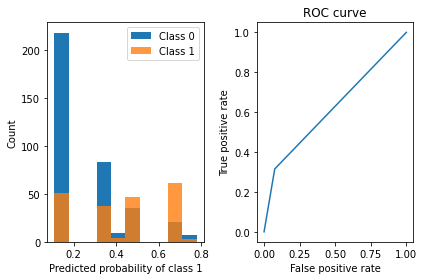

In [47]:
model = BayesianRuleListClassifier(max_iter=3000, class1label="diabetes", verbose=False)
model.fit(X_train_disc.to_numpy(), y_train, feature_names=X_train_disc.columns)
probs = model.predict_proba(X_test_disc)
preds = model.predict(X_test_disc.to_numpy(), threshold=0.5)

print("RuleListClassifier Accuracy:", np.mean(y_test == preds), "\n Learned interpretable model:\n", model)

viz_classification_preds(probs, y_test)

### Rule sets


Rule sets are models that create a set of (potentially overlapping) rules.

#### Rulefit 

It fits a sparse linear model on rules extracted from decision trees

In [48]:
# fit a rulefit model
model = RuleFitRegressor(max_rules=10)
model.fit(X_train_reg, y_train_reg, feature_names=feat_names_reg)

# get test performance
preds = model.predict(X_test_reg)
print(f'test mse: {metrics.mean_squared_error(y_test_reg, preds):0.2f}')
print(f'test r2: {metrics.r2_score(y_test_reg, preds):0.2f}')


# inspect and print the rules
#rules = model._get_rules()
#rules = rules[rules.coef != 0].sort_values("support", ascending=False)
# 'rule' is how the feature is constructed
# 'coef' is its weight in the final linear model
# 'support' is the fraction of points it applies to
#rules[['rule', 'coef', 'support']].style.background_gradient(cmap='viridis')
model

test mse: 2137540059.73
test r2: 0.66


RuleFitRegressor(max_rules=10)

In [53]:
model._get_rules()

,rule,type,coef,support,importance
0,MSSubClass,linear,-0.000000,1.000000,0.000000
1,LotArea,linear,0.000000,1.000000,0.000000
2,OverallQual,linear,17284.992985,1.000000,22228.149272
3,OverallCond,linear,0.000000,1.000000,0.000000
4,YearBuilt,linear,0.000000,1.000000,0.000000
5,YearRemodAdd,linear,0.000000,1.000000,0.000000
6,BsmtFinSF1,linear,0.000000,1.000000,0.000000
7,BsmtFinSF2,linear,-0.000000,1.000000,0.000000
8,BsmtUnfSF,linear,0.000000,1.000000,0.000000
9,TotalBsmtSF,linear,5.831596,1.000000,2534.790827


In [52]:
rules = model._get_rules()
rules = rules[rules.coef != 0].sort_values("support", ascending=False)
# 'rule' is how the feature is constructed
# 'coef' is its weight in the final linear model
# 'support' is the fraction of points it applies to
rules[['rule', 'coef', 'support']].style.background_gradient(cmap='viridis')

,rule,coef,support
2,OverallQual,17284.992985,1.000000
9,TotalBsmtSF,5.831596,1.000000
13,GrLivArea,33.245691,1.000000
23,GarageArea,23.202860,1.000000
37,GrLivArea <= 1744.0,-985.518100,0.769863
36,GrLivArea <= 2251.5 and TotalBsmtSF <= 1427.0,-18656.028993,0.758904
33,OverallQual <= 6.5 and GarageArea <= 686.5,-577.936769,0.605479
34,GrLivArea <= 1821.0 and YearBuilt <= 1997.0,-4900.542799,0.583562
35,YearBuilt <= 1994.5 and TotalBsmtSF <= 1304.0,-2046.991565,0.550685
38,GrLivArea > 1744.0,212.365112,0.230137


### Ruletree

#### FIGSClassifier

Classifier Accuracy: 0.7152777777777778 
 Learned interpretable model:
 > ------------------------------
> FIGS-Fast Interpretable Greedy-Tree Sums:
> 	Predictions are made by summing the "Val" reached by traversing each tree.
> 	For classifiers, a sigmoid function is then applied to the sum.
> ------------------------------
Glucose concentration test <= 99.500 (Tree #0 root)
	Val: 0.068 (leaf)
	Glucose concentration test <= 168.500 (split)
		#Pregnant <= 6.500 (split)
			Body mass index <= 30.850 (split)
				Val: 0.065 (leaf)
				Blood pressure(mmHg) <= 67.000 (split)
					Val: 0.705 (leaf)
					Val: 0.303 (leaf)
			Val: 0.639 (leaf)
		Blood pressure(mmHg) <= 93.000 (split)
			Val: 0.860 (leaf)
			Val: -0.009 (leaf)

	+
Diabetes pedigree function <= 0.404 (Tree #1 root)
	Val: -0.088 (leaf)
	Val: 0.106 (leaf)



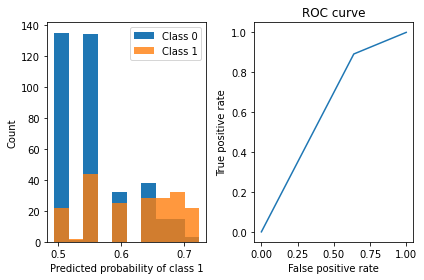

In [27]:
# specify a decision tree with a maximum depth
figs = FIGSClassifier(max_rules=7)
figs.fit(X_train, y_train, feature_names=feat_names)

# calculate mse on the training data
probs = figs.predict_proba(X_test)
preds = figs.predict(X_test)

print("Classifier Accuracy:", np.mean(y_test == preds), "\n Learned interpretable model:\n", figs)

viz_classification_preds(probs, y_test)

Alternative visualization:


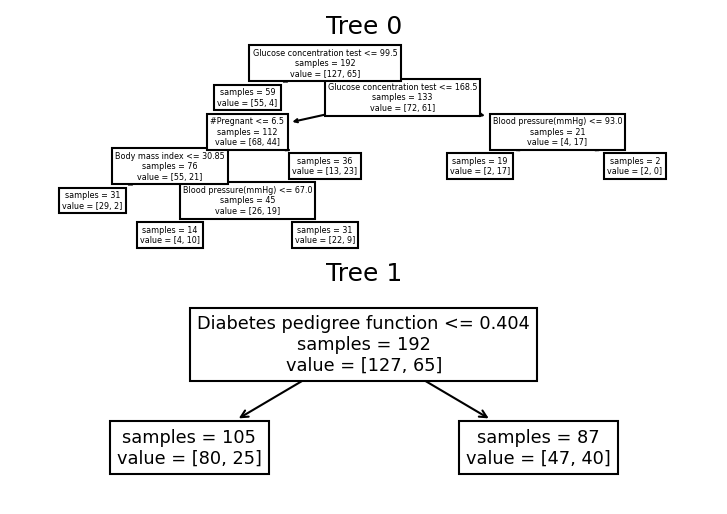

In [28]:
print('Alternative visualization:')
figs.plot()

In [33]:
dt = extract_sklearn_tree_from_figs(figs, tree_num=0, n_classes=2) # tree_num =  0 or 1
viz_model = dtreeviz.model(dt,
                           X_train=X_train, y_train=y_train,
                           feature_names=feat_names,
                           target_name='y', class_names=[0, 1])

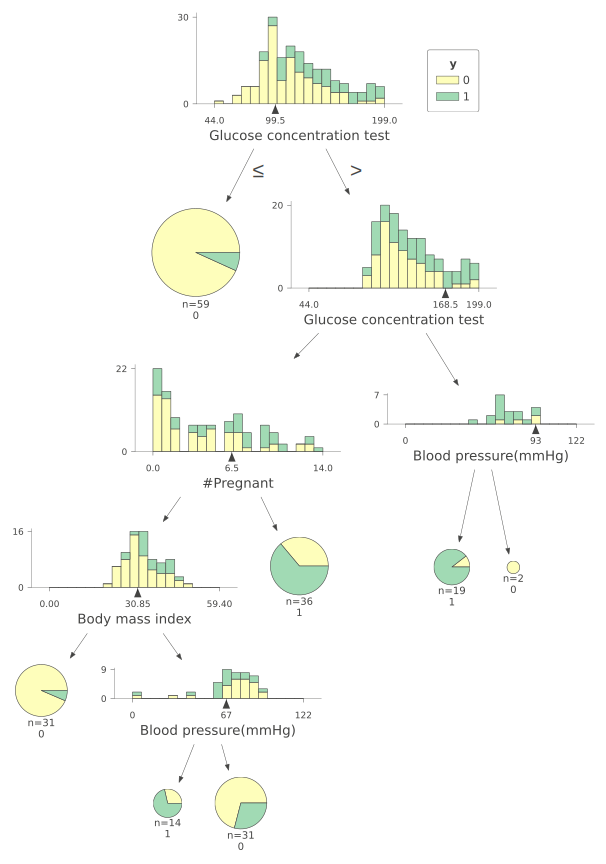

In [34]:
viz_model.view(scale=1.5)

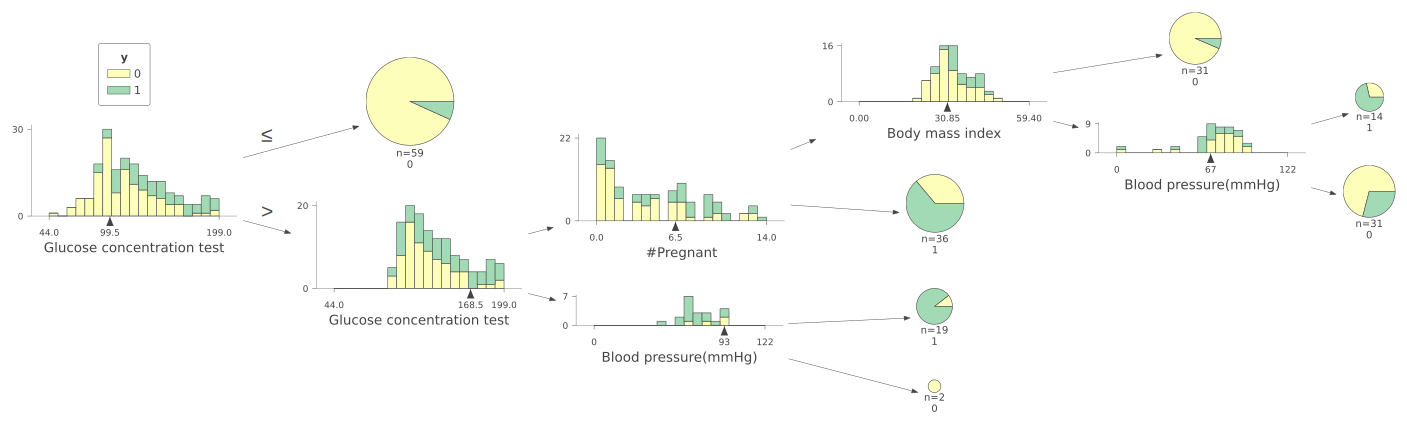

In [35]:
viz_model.view(orientation="LR", scale=1.5)

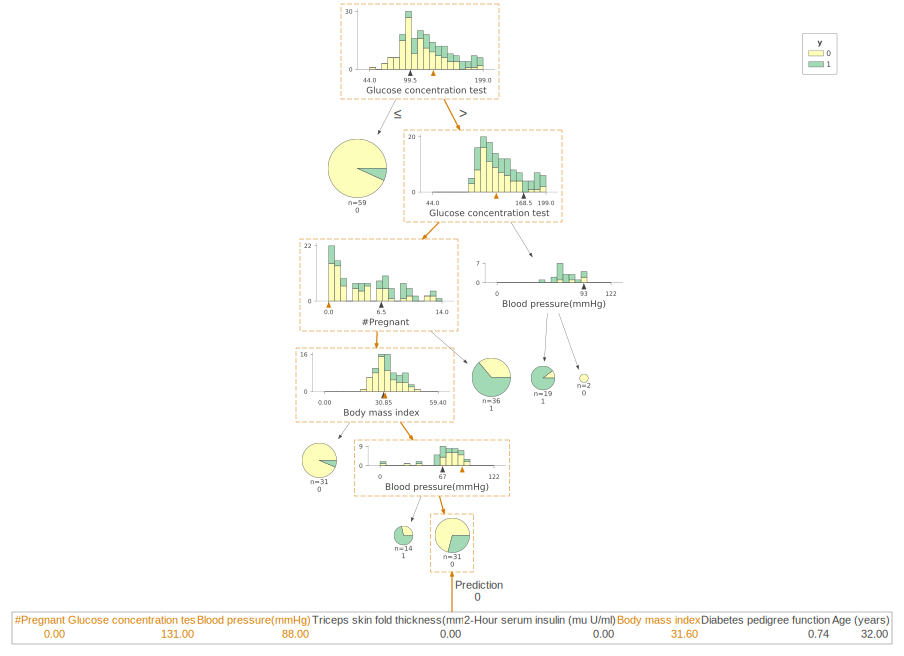

In [36]:
x_example = X_train[13]
viz_model.view(x=x_example)

See https://github.com/parrt/dtreeviz/blob/master/notebooks/dtreeviz_sklearn_visualisations.ipynb for more information.

#### HSTreeClassifier

Classifier Accuracy: 0.7291666666666666 
 Learned interpretable model:
 > ------------------------------
> Decision Tree with Hierarchical Shrinkage
> 	Prediction is made by looking at the value in the appropriate leaf of the tree
> ------------------------------
|--- feature_1 <= 99.50
|   |--- weights: [0.84, 0.16] class: 0.0
|--- feature_1 >  99.50
|   |--- feature_1 <= 168.50
|   |   |--- feature_0 <= 6.50
|   |   |   |--- feature_5 <= 30.85
|   |   |   |   |--- weights: [0.77, 0.23] class: 0.0
|   |   |   |--- feature_5 >  30.85
|   |   |   |   |--- feature_2 <= 67.00
|   |   |   |   |   |--- weights: [0.53, 0.47] class: 0.0
|   |   |   |   |--- feature_2 >  67.00
|   |   |   |   |   |--- weights: [0.66, 0.34] class: 0.0
|   |   |--- feature_0 >  6.50
|   |   |   |--- feature_6 <= 0.26
|   |   |   |   |--- weights: [0.57, 0.43] class: 0.0
|   |   |   |--- feature_6 >  0.26
|   |   |   |   |--- weights: [0.45, 0.55] class: 1.0
|   |--- feature_1 >  168.50
|   |   |--- weights: [0.3

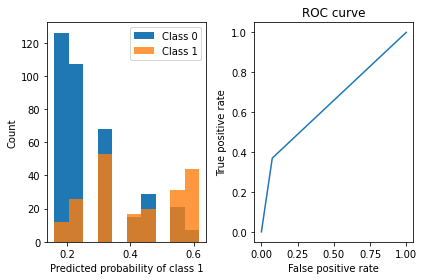

In [37]:
# specify a decision tree with a maximum depth
dt = HSTreeClassifierCV(max_leaf_nodes=7)
dt.fit(X_train, y_train, feature_names=feat_names)

# calculate mse on the training data
probs = dt.predict_proba(X_test)
preds = dt.predict(X_test)

print("Classifier Accuracy:", np.mean(y_test == preds), "\n Learned interpretable model:\n", dt)

viz_classification_preds(probs, y_test)

Alternative visualization:


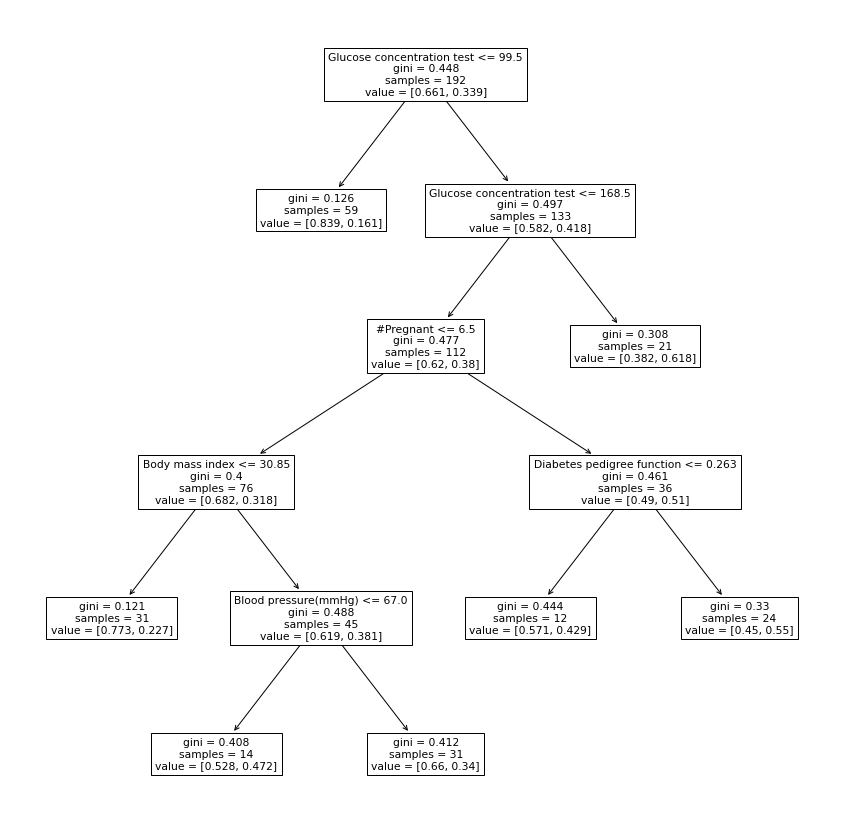

In [22]:
print('Alternative visualization:')
fig = plt.figure(figsize=(15, 15))
plot_tree(dt.estimator_, feature_names=feat_names)
plt.show()

## Partial Depedency Plot and Individual Conditional Expectation plots

Partial dependence plots (PDP) and individual conditional expectation (ICE) plots can be used to visualize and analyze interaction between the target response 1 and a set of input features of interest.

Both PDPs and ICEs **assume that the input features of interest are independent from the complement features**, and this assumption is often violated in practice. Thus, in the case of correlated features, we will create absurd data points to compute the PDP/ICE.

### Partial dependence plots

Partial dependence plots (PDP) show the dependence between the target response and a set of input features of interest, **marginalizing over the values of all other input features (the 'complement' features).** Intuitively, we can interpret the partial dependence as the expected target response as a function of the input features of interest.

Due to the limits of human perception the size of the set of input feature of interest must be small (usually, one or two) **thus the input features of interest are usually chosen among the most important features.**



In [54]:
cal_housing = fetch_california_housing()
X = pd.DataFrame(cal_housing.data, columns=cal_housing.feature_names)
y = cal_housing.target

y -= y.mean()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

#### 1-way partial dependence with different models

Note that it is important to **check that the model is accurate enough on a test set before plotting the partial dependence** since there would be little use in explaining the impact of a given feature on the prediction function of a poor model.

In [55]:
est = HistGradientBoostingRegressor(random_state=0) # Similar to lightgbm
est.fit(X_train, y_train)
print(f"Test R2 score: {est.score(X_test, y_test):.2f}")

Test R2 score: 0.85


The `sklearn.inspection` module provides a convenience function `from_estimator` to create one-way and two-way partial dependence plots.

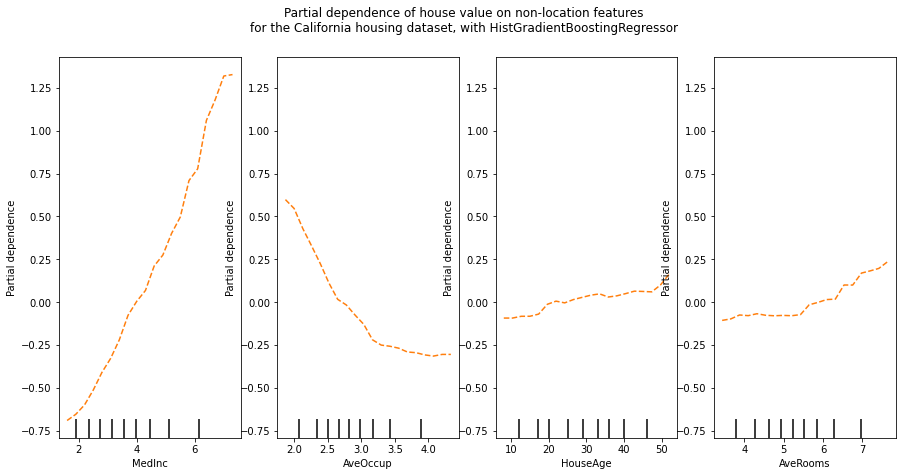

In [64]:
features = ["MedInc", "AveOccup", "HouseAge", "AveRooms"]
_, ax = plt.subplots(ncols=4, figsize=(15, 7))
display = PartialDependenceDisplay.from_estimator(
    est,
    X_train,
    features,
    grid_resolution=20,
    ax = ax,
    random_state=0,
    pd_line_kw={"color": "tab:orange", "linestyle": "--"}
)
display.figure_.suptitle(
    "Partial dependence of house value on non-location features\n"
    "for the California housing dataset, with HistGradientBoostingRegressor"
)
display.figure_.subplots_adjust(hspace=2)

We can clearly see on the PDPs (dashed orange line) that the median house price shows a linear relationship with the median income (left) and that the house price drops when the average occupants per household increases (middle). The right plots show that the house age in a district does not have a strong influence on the (median) house price; so does the average rooms per household.

One-way PDPs tell us about the interaction between the target response and an input feature of interest feature (e.g. linear, non-linear). 

#### 2D Partial Dependence Plots

PDPs with two features of interest enable us to visualize interactions among them. Another consideration is linked to the performance to compute the PDPs. With the tree-based algorithm, when only PDPs are requested, they can be computed on an efficient way using the 'recursion' method.

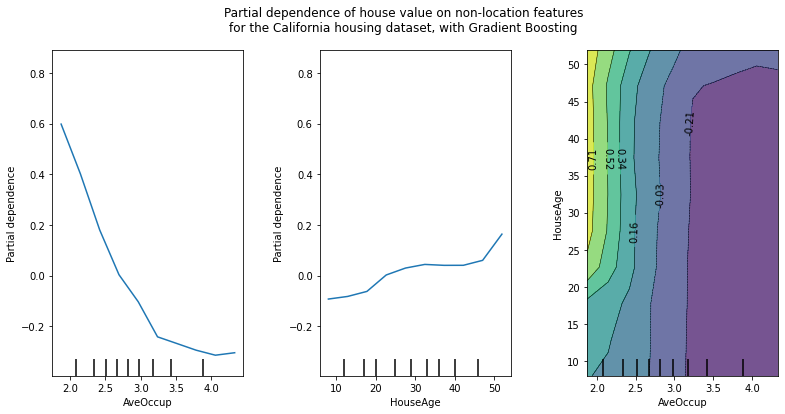

In [65]:
features = ["AveOccup", "HouseAge", ("AveOccup", "HouseAge")]
_, ax = plt.subplots(ncols=3, figsize=(13, 6))
display = PartialDependenceDisplay.from_estimator(
    est,
    X_train,
    features,
    kind="average",
    grid_resolution=10,
    ax=ax,
)

display.figure_.suptitle(
    "Partial dependence of house value on non-location features\n"
    "for the California housing dataset, with Gradient Boosting"
)
display.figure_.subplots_adjust(wspace=0.4, hspace=0.3)

The left plot in the above figure shows the effect of the average occupancy on the median house price; we can clearly see a linear relationship among them when the average occupancy is inferior to 3 persons. Similarly, we could analyze the effect of the house age on the median house price (middle plot). Thus, these interpretations are marginal, considering a feature at a time.

The two-way partial dependence plot shows the dependence of median house price on joint values of house age and average occupants per household. We can clearly see an interaction between the two features: **for an average occupancy greater than two, the house price is nearly independent of the house age, whereas for values less than two there is a strong dependence on age.**

If you need the raw values of the partial dependence function rather than the plots, you can use the `sklearn.inspection.partial_dependence()` function.

#### Another example

Like permutation importance, partial dependence plots are calculated **after a model has been fit.** The model is fit on real data that has not been artificially manipulated in any way. Our example will use a model that predicts whether a soccer/football team will have the "Man of the Game" winner based on the team's statistics. The "Man of the Game" award is given to the best player in the game. 

Teams may differ in many ways. How many passes they made, shots they took, goals they scored, etc. At first glance, it seems difficult to disentangle the effect of these features. To see how partial plots separate out the effect of each feature, we start by considering a single row of data. For example, that row of data might represent a team that had the ball 50% of the time, made 100 passes, took 10 shots and scored 1 goal.

We will use the fitted model to predict our outcome (probability their player won "man of the match"). **But we repeatedly alter the value for one variable to make a series of predictions.** We could predict the outcome if the team had the ball only 40% of the time. We then predict with them having the ball 50% of the time. Then predict again for 60%. And so on. We trace out predicted outcomes (on the vertical axis) as we move from small values of ball possession to large values (on the horizontal axis).

In this description, we used only a single row of data. Interactions between features may cause the plot for a single row to be atypical. So, we repeat that mental experiment with multiple rows from the original dataset, and we plot the average predicted outcome on the vertical axis.

In [66]:
data = pd.read_csv('FIFA 2018 Statistics.csv')
y = (data['Man of the Match'] == "Yes")  # Convert from string "Yes"/"No" to binary
feature_names = [i for i in data.columns if data[i].dtype in [np.int64]]
X = data[feature_names]
X

,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,Offsides,Free Kicks,Saves,Pass Accuracy %,Passes,Distance Covered (Kms),Fouls Committed,Yellow Card,Yellow & Red,Red,Goals in PSO
0,5,40,13,7,3,3,6,3,11,0,78,306,118,22,0,0,0,0
1,0,60,6,0,3,3,2,1,25,2,86,511,105,10,0,0,0,0
2,0,43,8,3,3,2,0,1,7,3,78,395,112,12,2,0,0,0
3,1,57,14,4,6,4,5,1,13,3,86,589,111,6,0,0,0,0
4,0,64,13,3,6,4,5,0,14,2,86,433,101,22,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,1,46,11,1,6,4,4,3,24,5,79,479,148,14,1,0,0,0
124,2,43,12,4,3,5,4,1,5,5,88,510,108,11,1,0,0,0
125,0,57,15,5,7,3,5,0,12,2,92,698,110,5,2,0,0,0
126,4,39,8,6,1,1,2,1,14,1,75,271,99,14,2,0,0,0


In [67]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
tree_model = DecisionTreeClassifier(random_state=0, max_depth=5, min_samples_split=5).fit(train_X, train_y)

Our first example uses a decision tree, which you can see below. In practice, you'll use more sophistated models for real-world applications.

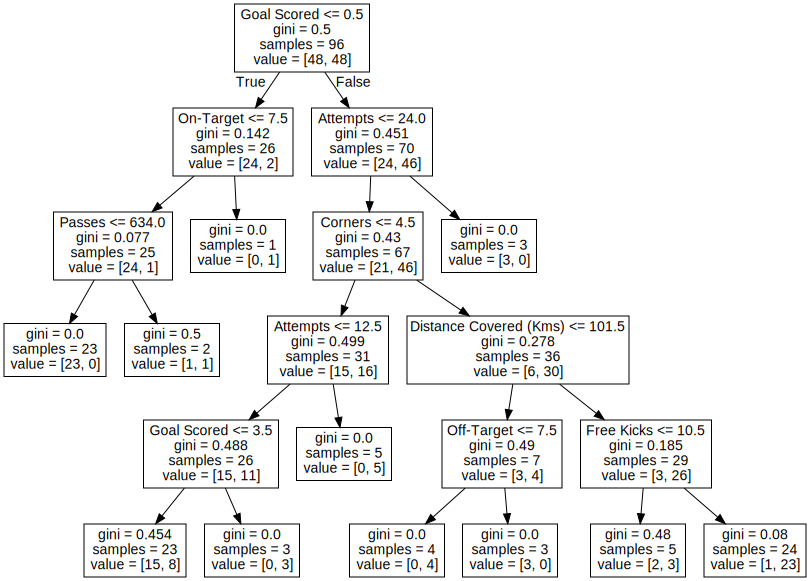

In [68]:
tree_graph = tree.export_graphviz(tree_model, out_file=None, feature_names=feature_names)
graphviz.Source(tree_graph)

In [69]:
feature_names

['Goal Scored',
 'Ball Possession %',
 'Attempts',
 'On-Target',
 'Off-Target',
 'Blocked',
 'Corners',
 'Offsides',
 'Free Kicks',
 'Saves',
 'Pass Accuracy %',
 'Passes',
 'Distance Covered (Kms)',
 'Fouls Committed',
 'Yellow Card',
 'Yellow & Red',
 'Red',
 'Goals in PSO']

(0.0, 1.0)

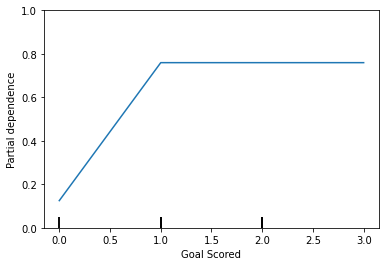

In [70]:
PartialDependenceDisplay.from_estimator(tree_model, val_X, features=['Goal Scored'], feature_names=feature_names)
plt.ylim(0,1)

A few items are worth pointing out as you interpret this plot

* The y axis is interpreted as **change in the prediction** from what it would be predicted at the baseline or leftmost value.
* A blue shaded area indicates level of confidence

From this particular graph, we see that scoring a goal substantially increases your chances of winning "Man of The Match."  But extra goals beyond that appear to have little impact on predictions.

Here is another example plot:

(0.0, 2.0)

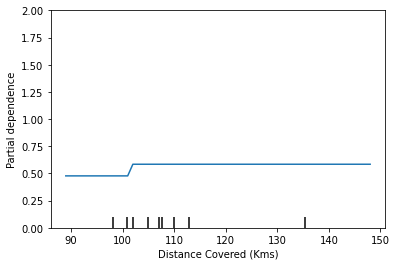

In [71]:
PartialDependenceDisplay.from_estimator(tree_model, val_X, features=['Distance Covered (Kms)'], feature_names=feature_names)
plt.ylim(0,2)

This graph seems too simple to represent reality. But that's because the model is so simple. You should be able to see from the decision tree above that this is representing exactly the model's structure.

You can easily compare the structure or implications of different models. Here is the same plot with a Random Forest model.

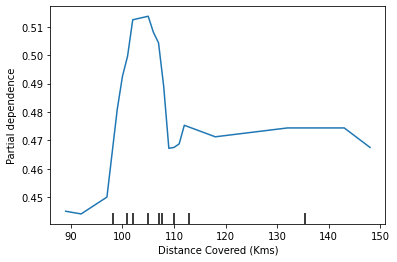

In [72]:
# Build Random Forest model
rf_model = RandomForestClassifier(random_state=0).fit(train_X, train_y)

PartialDependenceDisplay.from_estimator(rf_model, val_X, features=['Distance Covered (Kms)'], feature_names=feature_names)


This model thinks you are more likely to win *Man of the Match* if your players run a total of 100km over the course of the game. Though running much more causes lower predictions.

In general, the smooth shape of this curve seems more plausible than the step function from the Decision Tree model.  Though this dataset is small enough that we would be careful in how we interpret any model.

If you are curious about interactions between features, 2D partial dependence plots are also useful. An example may clarify this.  

We will again use the Decision Tree model for this graph.  It will create an extremely simple plot, but you should be able to match what you see in the plot to the tree itself.

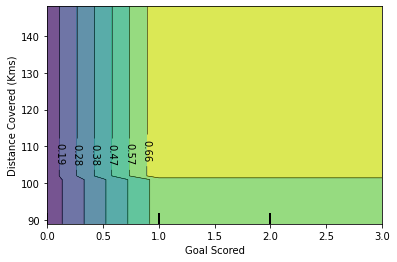

In [73]:
# Similar to previous PDP plot
PartialDependenceDisplay.from_estimator(tree_model, val_X, features=[('Goal Scored', 'Distance Covered (Kms)')], feature_names=feature_names)

This graph shows predictions for any combination of Goals Scored and Distance covered.

For example, we see the highest predictions when a team scores at least 1 goal and they run a total distance close to 100km. If they score 0 goals, distance covered doesn't matter. Can you see this by tracing through the decision tree with 0 goals?

But distance can impact predictions if they score goals. Make sure you can see this from the 2D partial dependence plot. Can you see this pattern in the decision tree too?

###  Individual conditional expectation (ICE) plot

Due to the limits of human perception, **only one input feature** of interest is supported for ICE plots.

While the PDPs are good at showing the average effect of the target features, they can obscure a **heterogeneous relationship** created by interactions. When interactions are present the ICE plot will provide many more insights. For example, we could observe a linear relationship between the median income and the house price in the PD line. However, the ICE lines show that there are some exceptions, where the house price remains constant in some ranges of the median income. We will plot the partial dependence, both individual (ICE) and averaged one (PDP). We limit to only 50 ICE curves to not overcrowd the plot.

The sklearn.inspection module’s `PartialDependenceDisplay.from_estimator `convenience function can be used to create ICE plots by setting `kind='individual'`. But in ICE plots it might not be easy to see the average effect of the input feature of interest. Hence, it is recommended to use ICE plots alongside PDPs. They can be plotted together with `kind='both'`.

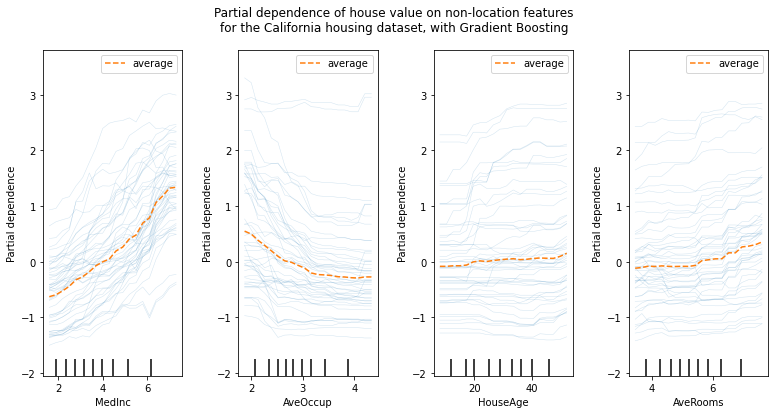

In [76]:
features = ["MedInc", "AveOccup", "HouseAge", "AveRooms"]
_, ax = plt.subplots(ncols=4, figsize=(13, 6))
display = PartialDependenceDisplay.from_estimator(
    est,
    X_train,
    features,
    kind="both",
    subsample=50,
    n_jobs=3,
    grid_resolution=20,
    random_state=0,
    ax = ax, 
    ice_lines_kw={"color": "tab:blue", "alpha": 0.2, "linewidth": 0.5},
    pd_line_kw={"color": "tab:orange", "linestyle": "--"},
)
display.figure_.suptitle(
    "Partial dependence of house value on non-location features\n"
    "for the California housing dataset, with Gradient Boosting"
)
display.figure_.subplots_adjust(wspace=0.4, hspace=0.3)

The ICE curves (light blue lines) complement the analysis: we can see that there are some exceptions, where the house price remain constant with median income and average occupants. On the other hand, while the house age (top right) does not have a strong influence on the median house price on average, **there seems to be a number of exceptions where the house price increase when between the ages 15-25.** Similar exceptions can be observed for the average number of rooms (bottom left). Therefore, ICE plots show some individual effect which are attenuated by taking the averages.

Checkout more information at https://scikit-learn.org/stable/modules/partial_dependence.html# or https://github.com/SauceCat/PDPbox

## LIME

We'll use the Iris dataset, and we'll train a random forest.

In [77]:
np.random.seed(1)
iris = load_iris()
train, test, labels_train, labels_test = train_test_split(iris.data, iris.target, train_size=0.8)

In [78]:
rf = RandomForestClassifier(n_estimators=500)
rf.fit(train, labels_train)
metrics.accuracy_score(labels_test, rf.predict(test))

0.9666666666666667

### Tabular data

#### Create the explainer

Tabular explainers need a training set. The reason for this is because we compute statistics on each feature (column). If the feature is numerical, we compute the mean and std, and discretize it into quartiles. If the feature is categorical, we compute the frequency of each value. For this part, we'll only look at numerical features.

We use these computed statistics for two things:

1. To scale the data, so that we can meaningfully compute distances when the attributes are not on the same scale
2. To sample perturbed instances - which we do by sampling from a `Normal(0,1)`, multiplying by the std and adding back the mean.

In [79]:
explainer = lime.lime_tabular.LimeTabularExplainer(train, feature_names=iris.feature_names, class_names=iris.target_names, discretize_continuous=True)

#### Explaining an instance

Since this is a multi-class classification problem, we set the `top_labels` parameter, so that we only explain the top class.

In [80]:
i = np.random.randint(0, test.shape[0])
exp = explainer.explain_instance(test[i], rf.predict_proba, num_features=2, top_labels=1)

We now explain a single instance:

In [99]:
exp.show_in_notebook(show_table=True, show_all=True)

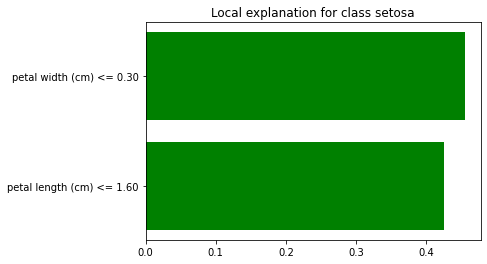

In [97]:
fig = exp.as_pyplot_figure(label=0)

Now, there is a lot going on here. First, note that the row we are explained is displayed on the right side, in table format. Since we had the `show_all` parameter set to false, only the features used in the explanation are displayed.
The value column displays the original value for each feature.

Note that LIME has discretized the features in the explanation. This is because we let `discretize_continuous=True` in the constructor (this is the default). Discretized features make for more intuitive explanations.

### Image data

In [138]:
inet_model = tf.keras.applications.inception_v3.InceptionV3()

In [139]:
!wget https://raw.githubusercontent.com/marcotcr/lime/master/doc/notebooks/data/cat_mouse.jpg

--2023-03-26 14:01:28--  https://raw.githubusercontent.com/marcotcr/lime/master/doc/notebooks/data/cat_mouse.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248960 (243K) [image/jpeg]
Saving to: ‘cat_mouse.jpg.1’

cat_mouse.jpg.1     100%[===================>] 243.12K  --.-KB/s    in 0.03s   

2023-03-26 14:01:28 (8.94 MB/s) - ‘cat_mouse.jpg.1’ saved [248960/248960]



In [140]:
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(299, 299))
        x = tf.keras.preprocessing.image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = tf.keras.applications.inception_v3.preprocess_input(x)
        out.append(x)
    return np.vstack(out)

1/1 [==============================] - 1s 1s/step
('n02133161', 'American_black_bear', 0.6371618)
('n02105056', 'groenendael', 0.031817783)
('n02104365', 'schipperke', 0.029944107)
('n01883070', 'wombat', 0.028509583)
('n01877812', 'wallaby', 0.025093373)


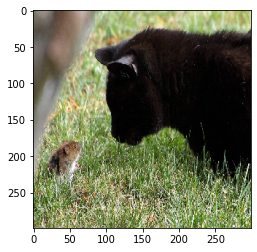

In [141]:
images = transform_img_fn(['cat_mouse.jpg'])
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(images[0] / 2 + 0.5)
preds = inet_model.predict(images)
for x in tf.keras.applications.imagenet_utils.decode_predictions(preds)[0]:
    print(x)

#### Explanation

Now let's get an explanation

In [142]:
explainer = lime_image.LimeImageExplainer()

In [ ]:
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(images[0].astype('double'), inet_model.predict, top_labels=5, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


#### Now let's see the explanation for the classes

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

We can also see the 'pros and cons' (pros in green, cons in red)

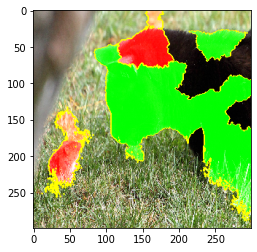

In [112]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Alternatively, we can also plot explanation weights onto a heatmap visualization. The colorbar shows the values of the weights.

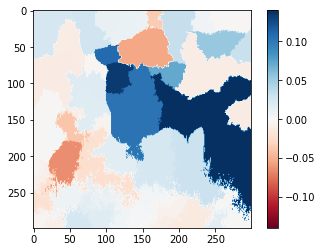

In [113]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

In [114]:
dict_heatmap

{25: 0.13992466839544324,
 20: 0.1337846627421158,
 14: 0.10909272205921074,
 26: 0.1031597130849429,
 17: 0.07114455347769996,
 34: -0.06458889817454885,
 10: -0.054259648013934694,
 11: 0.052656221790156194,
 28: -0.03922202025190241,
 0: -0.03569558757601254,
 12: 0.03277165982487321,
 3: 0.03258070593330946,
 13: 0.03148510835156708,
 31: 0.030155986661486,
 5: 0.028355095604468986,
 48: 0.02503565063428401,
 38: 0.024859610987521104,
 32: 0.024521926381942328,
 8: 0.02354687919824106,
 35: -0.023314438840587814,
 37: -0.023087611305411575,
 29: -0.021788611376394953,
 44: -0.02112468839876225,
 18: 0.017760555094577014,
 46: 0.017255358231002226,
 21: 0.01716877136110519,
 50: 0.01576144232210514,
 33: 0.01526938696303869,
 53: -0.013936401928018656,
 40: 0.013623022386429538,
 24: -0.011615786810296139,
 16: -0.011146086207049263,
 1: 0.01060383772710084,
 9: -0.010580780607886113,
 19: -0.010464941065088834,
 6: 0.0093481617576145,
 43: 0.008427852024928321,
 23: -0.008421377077

Let's see the explanation for the wombat

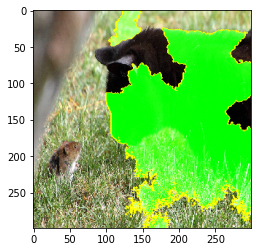

In [115]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[3], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

For more information, please refer to https://github.com/marcotcr/lime

## SHAP

### The force plot

An example is helpful, and we'll continue the soccer/football example from the partial dependence plots. In these part, we predicted whether **a team would have a player win the Man of the Match award.**

We could ask:
* How much was a prediction driven by the fact that the team scored 3 goals?

But it's easier to give a concrete, numeric answer if we restate this as:
* How much was a prediction driven by the fact that the team scored 3 goals, instead of some baseline number of goals.

Of course, each team has many features. So if we answer this question for number of goals, we could repeat the process for all other features.

In [116]:
data = pd.read_csv('FIFA 2018 Statistics.csv')
y = (data['Man of the Match'] == "Yes")  # Convert from string "Yes"/"No" to binary
feature_names = [i for i in data.columns if data[i].dtype in [np.int64, np.int64]]
X = data[feature_names]
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
my_model = RandomForestClassifier(random_state=0).fit(train_X, train_y)

We will look at SHAP values for a single row of the dataset (we arbitrarily chose row 5). For context, we'll look at the raw predictions before looking at the SHAP values.

In [117]:
row_to_show = 5
data_for_prediction = val_X.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
#data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

my_model.predict_proba(data_for_prediction.values.reshape(1, -1))

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names


array([[0.29, 0.71]])

The team is 71% likely to have a player win the award. 
Now, we'll move onto the code to get SHAP values for that single prediction.

In [118]:
# Create object that can calculate shap values
explainer = shap.Explainer(my_model)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)

The `shap_values` object above is a list with two arrays. The first array is the SHAP values for a negative outcome (don't win the award), and the second array is the list of SHAP values for the positive outcome (wins the award). We typically think about predictions in terms of the prediction of a positive outcome, so we'll pull out SHAP values for positive outcomes (pulling out `shap_values[1]`).

It's cumbersome to review raw arrays, but the shap package has a nice way to visualize the results. 

In [125]:
shap.initjs()
shap.plots.force(explainer.expected_value[1], shap_values[1], data_for_prediction) # You can use view output in full screen

If you look carefully at the code where we created the SHAP values, you'll notice we reference Trees in `shap.TreeExplainer(my_model)`.  But the SHAP package has explainers for every type of model.

* `shap.DeepExplainer` works with Deep Learning models. 
* `shap.KernelExplainer` works with all models, though it is slower than other Explainers and it offers an approximation rather than exact Shap values.

### Summary Plots

In addition to this nice breakdown for each prediction, the [Shap library](https://github.com/slundberg/shap) offers great visualizations of groups of Shap values. We will focus on two of these visualizations. These visualizations have conceptual similarities to permutation importance and partial dependence plots.

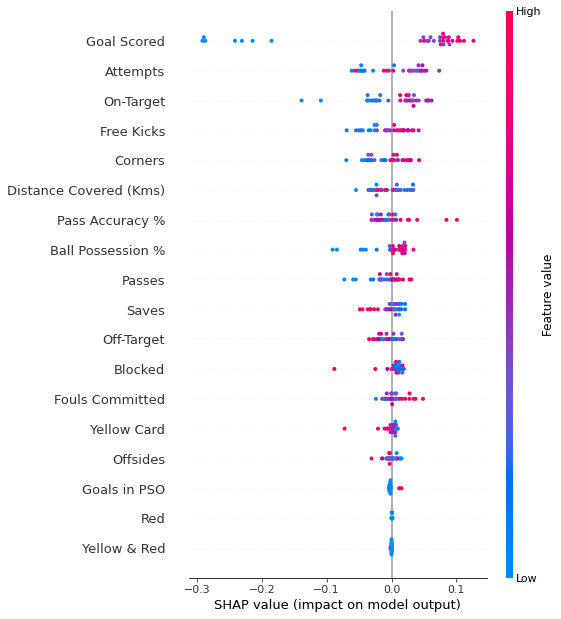

In [128]:
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(val_X)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values[1], val_X)

The code isn't too complex. But there are a few caveats.

* When plotting, we call `shap_values[1]`.  For classification problems, there is a separate array of SHAP values for each possible outcome. In this case, **we index in to get the SHAP values for the prediction of "True".**
* Calculating SHAP values can be slow. It isn't a problem here, because this dataset is small.  But you'll want to be careful when running these to plot with reasonably sized datasets.  The exception is when using an `xgboost` model, which SHAP has some optimizations for and which is thus much faster.

This provides a great overview of the model, but we might want to delve into a single feature. That's where SHAP dependence contribution plots come into play.

### Dependence Contribution Plots

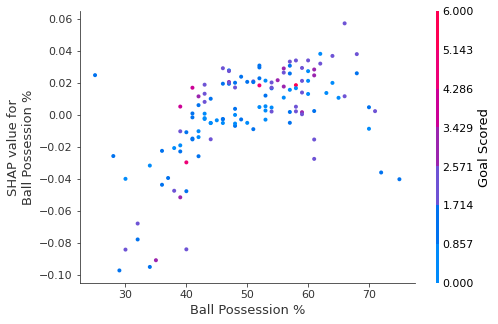

In [129]:
# calculate shap values. This is what we will plot.
shap_values = explainer.shap_values(X)

# make plot.
shap.dependence_plot('Ball Possession %', shap_values[1], X, interaction_index="Goal Scored")

### Image data

Deep SHAP is a high-speed approximation algorithm for SHAP values in deep learning models that builds on a connection with DeepLIFT. The implementation here differs from the original DeepLIFT by using a distribution of background samples instead of a single reference value, and using Shapley equations to linearize components such as max, softmax, products, divisions, etc. Note that some of these enhancements have also been since integrated into DeepLIFT. 

In [134]:
batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Epoch 1/12
469/469 [==============================] - 6s 10ms/step - loss: 0.2432 - accuracy: 0.9260 - val_loss: 0.0584 - val_accuracy: 0.9812
Epoch 2/12
469/469 [==============================] - 4s 9ms/step - loss: 0.0902 - accuracy: 0.9730 - val_loss: 0.0448 - val_accuracy: 0.9854
Epoch 3/12
469/469 [==============================] - 5s 11ms/step - loss: 0.0676 - accuracy: 0.9797 - val_loss: 0.0351 - val_accuracy: 0.9882
Epoch 4/12
469/469 [==============================] - 6s 13ms/step - loss: 0.0550 - accuracy: 0.9830 - val_loss: 0.0335 - val_accuracy: 0.9904
Epoch 5/12
469/469 [==============================] - 6s 12ms/step - loss: 0.0471 - accuracy: 0.9856 - val_loss: 0.0289 - val_accuracy: 0.9896
Epoch 6/12
469/469 [==============================] - 6s 13ms/step - loss: 0.0400 - accuracy: 0.9878 - val_loss: 0.0279 - val_accuracy: 0.9910
Epoch 7/12
469/469 [==============================] - 5s 11ms/step - l

In [135]:
# select a set of background examples to take an expectation over
background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]

# explain predictions of the model on three images
e = shap.DeepExplainer(model, background)
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
shap_values = e.shap_values(x_test[1:5])

/usr/local/lib/python3.9/dist-packages/shap/explainers/_deep/deep_tf.py:100: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
/usr/local/lib/python3.9/dist-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [136]:
len(shap_values)

10

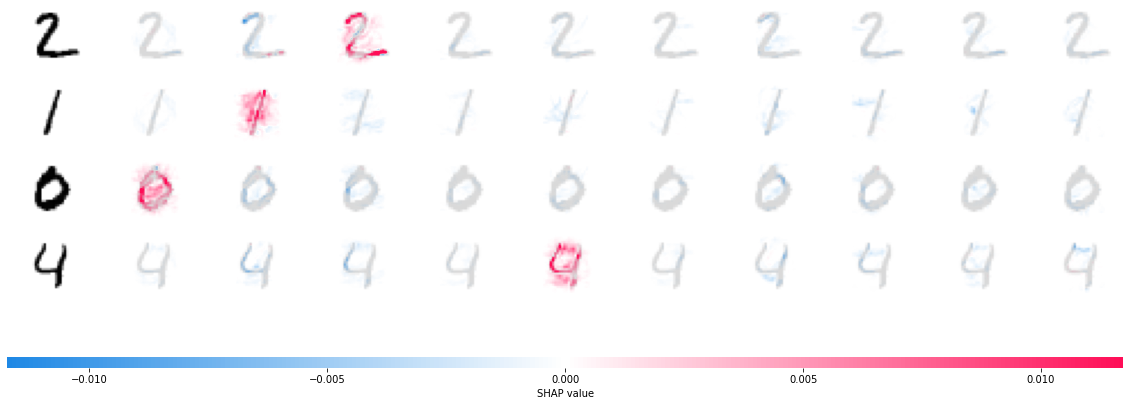

In [137]:
# plot the feature attributions
# 10 classes, thus we have 10 plots!
shap.image_plot(shap_values, -x_test[1:5])

The plot above explains ten outputs (digits 0-9) for four different images. Red pixels increase the model's output while blue pixels decrease the output. The input images are shown on the left, and as nearly transparent grayscale backings behind each of the explanations. The sum of the SHAP values equals the difference between the expected model output (averaged over the background dataset) and the current model output. Note that for the 'zero' image the blank middle is important, while for the 'four' image the lack of a connection on top makes it a four instead of a nine.

## Protodash using AXI360

You can find more examples here https://github.com/Trusted-AI/AIX360/tree/master/examples/protodash

## Counterfactual instances

You can find more informations here https://docs.seldon.io/projects/alibi/en/stable/methods/CFProto.html and https://github.com/interpretml/DiCE

## Using Interpretable Features for Model Debugging

You can find more informations here https://github.com/dcai-course/dcai-lab/blob/master/interpretable_features/Solution%20-%20Interpretable%20Features.ipynb

## References

1. https://www.kaggle.com/learn/machine-learning-explainability
2. https://scikit-learn.org/stable/modules/partial_dependence.html#, 
3. https://github.com/csinva/imodels
4. https://github.com/marcotcr/lime
5. https://github.com/slundberg/shap